In [1]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("DCIS_HF_TOKEN")
login(token=hf_token)

2025-08-29 00:44:29.171429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756428269.400164      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756428269.466364      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Initializing global attention on CLS token...


model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.992900,0.357978
2,1.153200,1.464024
3,0.629000,1.158353


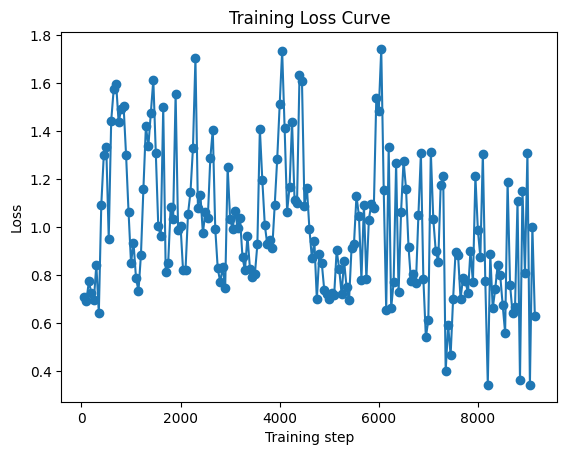

              precision    recall  f1-score   support

    Not DCIS       0.98      0.74      0.84       678
        DCIS       0.30      0.89      0.45        87

    accuracy                           0.75       765
   macro avg       0.64      0.81      0.65       765
weighted avg       0.90      0.75      0.80       765



In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import LongformerTokenizer, LongformerForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch.nn as nn

# Load dataset
training_df = pd.read_csv("/kaggle/input/bcttrainingdata/BCTTrainingData.csv")  # columns: "raw_text", "Patient Type"

# Encode labels (0 = not DCIS, 1 = DCIS)
def encode_labels(label_str):
    return 1 if "DCIS" in label_str else 0

training_df["encoded_labels"] = training_df["Patient Type"].apply(encode_labels)

# Split into train/validation
train_df = training_df.sample(frac=0.8, random_state=23)
val_df = training_df.drop(train_df.index)

class CancerStageDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=4096):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]["raw_text"]
        label = torch.tensor(self.df.iloc[idx]["encoded_labels"], dtype=torch.long)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item["labels"] = label
        return item

# Tokenizer
tokenizer = LongformerTokenizer.from_pretrained("yikuan8/Clinical-Longformer")

# Datasets
train_dataset = CancerStageDataset(train_df, tokenizer)
val_dataset = CancerStageDataset(val_df, tokenizer)

# Compute sample weights for WeightedRandomSampler
class_counts = train_df["encoded_labels"].value_counts().to_dict()
weights = train_df["encoded_labels"].map(lambda x: 0.5 / class_counts[x]).tolist()

sampler = WeightedRandomSampler(
    weights, 
    num_samples=len(train_df), 
    replacement=True
)


# Model
model = LongformerForSequenceClassification.from_pretrained(
    "yikuan8/Clinical-Longformer",
    num_labels=2,
    problem_type="single_label_classification"
)

# Custom Trainer to support sampler
class SamplerTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,  # <-- using WeightedRandomSampler
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

# Training args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    report_to="none"
)

# Trainer
trainer = SamplerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train
trainer.train()

# Plot training loss
loss_steps = [entry["step"] for entry in trainer.state.log_history if "loss" in entry]
loss_values = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]

plt.plot(loss_steps, loss_values, marker="o")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

# Predict on validation set
preds_output = trainer.predict(val_dataset)
y_pred = preds_output.predictions.argmax(axis=1)
y_true = [val_dataset[i]["labels"].item() for i in range(len(val_dataset))]

# Classification report
print(classification_report(y_true, y_pred, target_names=["Not DCIS", "DCIS"]))

In [3]:
# Pick a repo name
repo_name = "bct-dcis-prototype-longformer-model"

# Push model + tokenizer
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Xpsloan/bct-dcis-prototype-longformer-model/commit/3541053424bec110f7959e832b0a7a9b0ba9eebc', commit_message='Upload tokenizer', commit_description='', oid='3541053424bec110f7959e832b0a7a9b0ba9eebc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Xpsloan/bct-dcis-prototype-longformer-model', endpoint='https://huggingface.co', repo_type='model', repo_id='Xpsloan/bct-dcis-prototype-longformer-model'), pr_revision=None, pr_num=None)